# 05 – Geospatial Mapping of LSOA-to-LSOA Travel Times

This notebook explores pairwise travel times between Lower Layer Super Output Areas (LSOAs) within the NHS South West region using AGEM-derived travel time datasets.

### Objectives
- Visualise LSOA-to-LSOA travel flows across the South West
- Join travel time data to geographic boundaries (centroids & polygons)
- Map and analyse shortest and longest travel time corridors
- Prepare data for integration into diagnostic demand and access models

### Data Sources
- **LSOA_to_LSOA.csv**: Travel times (car, public transport – peak/non-peak)
- **LSOA 2021 Boundaries (England & Wales)**: Geospatial shapefiles
- **NHS SW LSOA List**: Subset of LSOAs covering the 7 Integrated Care Boards (ICBs)

### Tools
- `pandas`, `geopandas`, `matplotlib`, `contextily`
- EPSG: 3857 projection for mapping basemaps

> This work supports spatial accessibility modelling for NHS diagnostic service planning under the Phase 2 Community Diagnostic Centre (CDC) strategy.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Optional display settings
pd.set_option('display.max_columns', None)


In [5]:
# LSOA-to-LSOA travel times
travel_df = pd.read_csv(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/LSOA_to_LSOA.csv",
    header=None,
    names=[
        "origin_name",
        "destination_name",
        "travel_time_car",
        "travel_time_pt_peak",
        "travel_time_pt_nonpeak"
    ]
)



In [6]:
# Preview
travel_df.head()

,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922
2,E01014654,E01015202,123.315531,146.985531,148.025531
3,E01015028,E01029066,133.568645,255.878645,268.518645
4,E01015316,E01029066,112.233260,227.623260,221.623260


In [7]:
# Dataset shape
print("Dataset shape (rows, columns):", travel_df.shape)

# Show first 5 rows
print("\nHead of the dataset:")
print(travel_df.head())

# Summary stats for travel times
print("\nSummary statistics:")
print(travel_df[["travel_time_car", "travel_time_pt_peak", "travel_time_pt_nonpeak"]].describe())

# Range of travel times
print("\nTravel time ranges (min-max):")
for col in ["travel_time_car", "travel_time_pt_peak", "travel_time_pt_nonpeak"]:
    min_val = travel_df[col].min()
    max_val = travel_df[col].max()
    print(f"{col}: {min_val:.2f} – {max_val:.2f} minutes")

Dataset shape (rows, columns): (10017225, 5)

Head of the dataset:
  origin_name destination_name  travel_time_car  travel_time_pt_peak  \
0   E01022150        E01014950        42.748168            56.288168   
1   E01029238        E01033364        85.033922           126.483922   
2   E01014654        E01015202       123.315531           146.985531   
3   E01015028        E01029066       133.568645           255.878645   
4   E01015316        E01029066       112.233260           227.623260   

   travel_time_pt_nonpeak  
0               56.288168  
1              126.483922  
2              148.025531  
3              268.518645  
4              221.623260  

Summary statistics:
       travel_time_car  travel_time_pt_peak  travel_time_pt_nonpeak
count     9.969814e+06         9.567023e+06            9.446702e+06
mean      1.137661e+02         2.019800e+02            2.004560e+02
std       5.661097e+01         9.139357e+01            8.997089e+01
min       0.000000e+00         0.000000

In [8]:
origins = travel_df["origin_name"].nunique()
destinations = travel_df["destination_name"].nunique()
print(f"Unique origins: {origins}, destinations: {destinations}")


Unique origins: 3165, destinations: 3165


In [9]:
travel_df[["travel_time_pt_peak", "travel_time_pt_nonpeak"]].isna().sum()


travel_time_pt_peak       450202
travel_time_pt_nonpeak    570523
dtype: int64

In [10]:
self_travel = (travel_df["origin_name"] == travel_df["destination_name"]).sum()
zero_travel = (travel_df["travel_time_car"] == 0).sum()
print(f"Self-travel rows: {self_travel}, zero-travel car times: {zero_travel}")


Self-travel rows: 3165, zero-travel car times: 3165


Shape: (10017225, 5)

Missing values:
 origin_name                    0
destination_name               0
travel_time_car            47411
travel_time_pt_peak       450202
travel_time_pt_nonpeak    570523
dtype: int64

Summary statistics:
        travel_time_car  travel_time_pt_peak  travel_time_pt_nonpeak
count     9.966649e+06         9.563858e+06            9.443537e+06
mean      1.138022e+02         2.020468e+02            2.005231e+02
std       5.658364e+01         9.133479e+01            8.991108e+01
min       2.185997e-01         1.126416e+00            1.155007e+00
25%       6.763103e+01         1.340271e+02            1.335382e+02
50%       1.130320e+02         1.973795e+02            1.967680e+02
75%       1.520478e+02         2.600785e+02            2.588863e+02
max       3.116717e+02         6.423605e+02            6.457563e+02


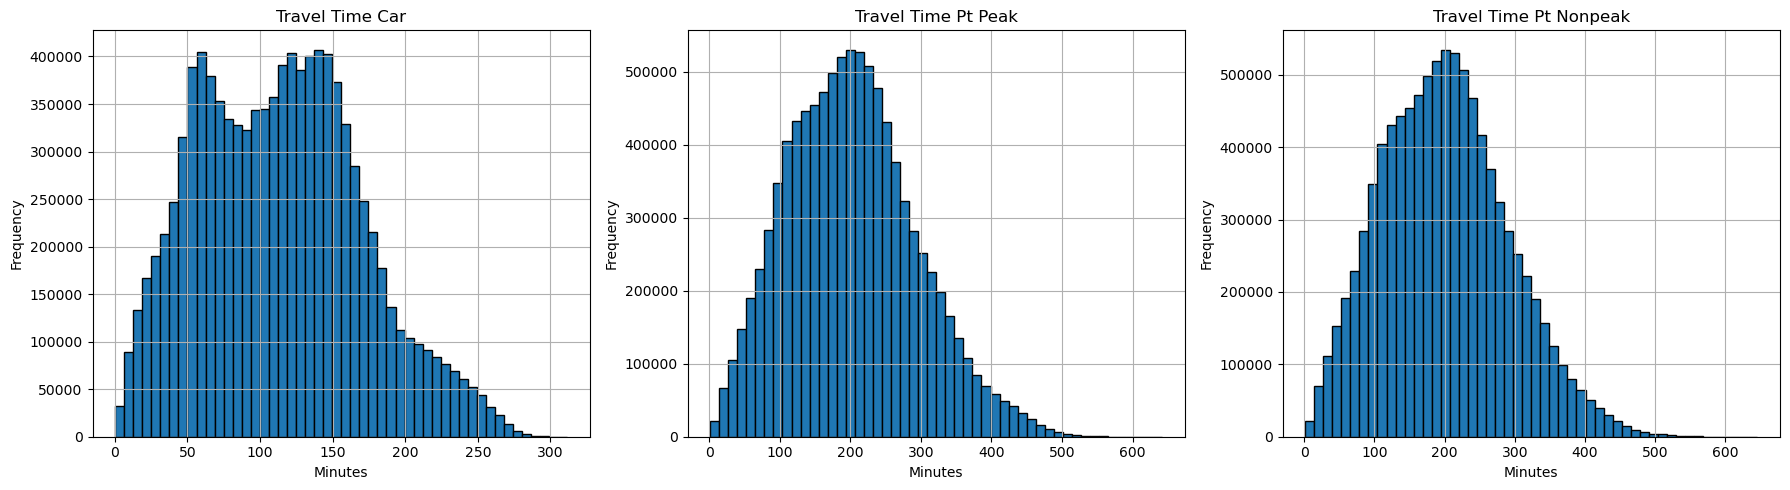

In [11]:
# Load CSV with column names
travel_df = pd.read_csv(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/LSOA_to_LSOA.csv",
    header=None,
    names=[
        "origin_name",
        "destination_name",
        "travel_time_car",
        "travel_time_pt_peak",
        "travel_time_pt_nonpeak"
    ]
)

# Shape and null checks
print("Shape:", travel_df.shape)
print("\nMissing values:\n", travel_df.isna().sum())

# Remove self-travel (for clearer histograms)
travel_df = travel_df[travel_df["origin_name"] != travel_df["destination_name"]]

# Summary stats
print("\nSummary statistics:\n", travel_df.describe())

# Histograms for each travel time
plt.figure(figsize=(18, 5))
for idx, col in enumerate(["travel_time_car", "travel_time_pt_peak", "travel_time_pt_nonpeak"], 1):
    plt.subplot(1, 3, idx)
    travel_df[col].dropna().hist(bins=50, edgecolor="black")
    plt.title(f"{col.replace('_', ' ').title()}")
    plt.xlabel("Minutes")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


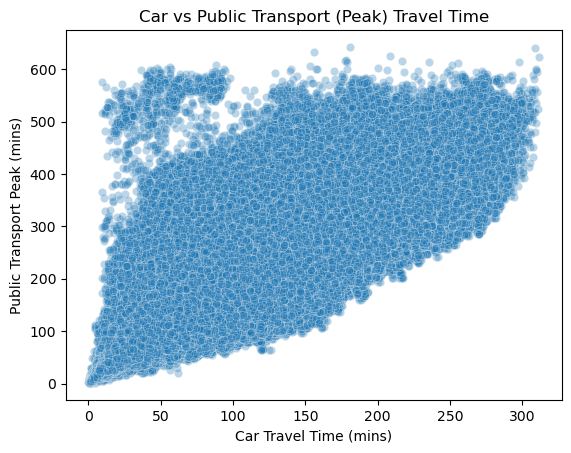

In [12]:
import seaborn as sns

sns.scatterplot(
    x=travel_df["travel_time_car"],
    y=travel_df["travel_time_pt_peak"],
    alpha=0.3
)
plt.title("Car vs Public Transport (Peak) Travel Time")
plt.xlabel("Car Travel Time (mins)")
plt.ylabel("Public Transport Peak (mins)")
plt.show()
